In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedShuffleSplit

In [2]:
# Load data
data = pd.read_excel('../data/data.xlsx')
data

,sequence,Episode 1,ID Episode 1,Runtime Episode 1,Time period Episode 1,Genres Episode 1,Rating Episode 1,Episode 2,ID Episode 2,Runtime Episode 2,Time period Episode 2,Genres Episode 2,Rating Episode 2,Episode 3,ID Episode 3,Runtime Episode 3,Time period Episode 3,Genres Episode 3,Rating Episode 3,Episode 4,ID Episode 4,Runtime Episode 4,Time period Episode 4,Genres Episode 4,Rating Episode 4,Episode 5,ID Episode 5,Runtime Episode 5,Time period Episode 5,Genres Episode 5,Rating Episode 5,Episode 6,ID Episode 6,Runtime Episode 6,Time period Episode 6,Genres Episode 6,Rating Episode 6,Episode 7,ID Episode 7,Runtime Episode 7,Time period Episode 7,Genres Episode 7,Rating Episode 7,Episode 8,ID Episode 8,Runtime Episode 8,Time period Episode 8,Genres Episode 8,Rating Episode 8,drama label,thriller label,action label,max_label
0,1806,Pink,4069937,56m,6 Months After the Heist,"{'drama': 0.41, 'thriller': 0.32, 'action': 0.27}",7.5,Red,4069936,36m,The Morning After the Heist,"{'drama': 0.22, 'thriller': 0.39, 'action': 0.39}",7.3,Violet,4069934,49m,24 Years Before the Heist,"{'drama': 0.62, 'thriller': 0.14, 'action': 0.24}",7.5,Green,3485676,46m,7 Years Before the Heist,"{'drama': 0.43, 'thriller': 0.19, 'action': 0.38}",7.2,Orange,4069935,52m,3 Weeks Before the Heist,"{'drama': 0.6, 'thriller': 0.25, 'action': 0.15}",7.1,Blue,4069266,48m,5 Days Before the Heist,"{'drama': 0.45, 'thriller': 0.4, 'action': 0.15}",7.2,Yellow,3483983,49m,6 Weeks Before the Heist,"{'drama': 0.14, 'thriller': 0.36, 'action': 0.5}",7.0,White,4069938,48m,The Heist,"{'drama': 0.0, 'thriller': 0.48, 'action': 0.52}",7.4,0.2078,0.5033,0.2889,thriller
1,9254,Yellow,3483983,49m,6 Weeks Before the Heist,"{'drama': 0.13, 'thriller': 0.39, 'action': 0.48}",7.0,Pink,4069937,56m,6 Months After the Heist,"{'drama': 0.43, 'thriller': 0.33, 'action': 0.24}",7.5,Green,3485676,46m,7 Years Before the Heist,"{'drama': 0.48, 'thriller': 0.19, 'action': 0.33}",7.2,Violet,4069934,49m,24 Years Before the Heist,"{'drama': 0.64, 'thriller': 0.18, 'action': 0.18}",7.5,Orange,4069935,52m,3 Weeks Before the Heist,"{'drama': 0.6, 'thriller': 0.25, 'action': 0.15}",7.1,Red,4069936,36m,The Morning After the Heist,"{'drama': 0.3, 'thriller': 0.35, 'action': 0.35}",7.3,Blue,4069266,48m,5 Days Before the Heist,"{'drama': 0.37, 'thriller': 0.42, 'action': 0.21}",7.2,White,4069938,48m,The Heist,"{'drama': 0.0, 'thriller': 0.48, 'action': 0.52}",7.4,0.1773,0.4173,0.4055,thriller
2,31441,Orange,4069935,52m,3 Weeks Before the Heist,"{'drama': 0.71, 'thriller': 0.14, 'action': 0.14}",7.1,Yellow,3483983,49m,6 Weeks Before the Heist,"{'drama': 0.14, 'thriller': 0.38, 'action': 0.48}",7.0,Green,3485676,46m,7 Years Before the Heist,"{'drama': 0.48, 'thriller': 0.19, 'action': 0.33}",7.2,White,4069938,48m,The Heist,"{'drama': 0.14, 'thriller': 0.38, 'action': 0.48}",7.4,Pink,4069937,56m,6 Months After the Heist,"{'drama': 0.5, 'thriller': 0.25, 'action': 0.25}",7.5,Red,4069936,36m,The Morning After the Heist,"{'drama': 0.3, 'thriller': 0.35, 'action': 0.35}",7.3,Violet,4069934,49m,24 Years Before the Heist,"{'drama': 0.57, 'thriller': 0.22, 'action': 0.22}",7.5,Blue,4069266,48m,5 Days Before the Heist,"{'drama': 0.38, 'thriller': 0.43, 'action': 0.19}",7.2,0.2683,0.3617,0.3700,action
3,18465,Blue,4069266,48m,5 Days Before the Heist,"{'drama': 0.56, 'thriller': 0.33, 'action': 0.11}",7.2,Red,4069936,36m,The Morning After the Heist,"{'drama': 0.22, 'thriller': 0.39, 'action': 0.39}",7.3,White,4069938,48m,The Heist,"{'drama': 0.14, 'thriller': 0.38, 'action': 0.48}",7.4,Green,3485676,46m,7 Years Before the Heist,"{'drama': 0.43, 'thriller': 0.19, 'action': 0.38}",7.2,Pink,4069937,56m,6 Months After the Heist,"{'drama': 0.5, 'thriller': 0.25, 'action': 0.25}",7.5,Yellow,3483983,49m,6 Weeks Before the Heist,"{'drama': 0.14, 'thriller': 0.38, 'action': 0.48}",7.0,Violet,4069934,49m,24 Years Before the Heist,"{'drama': 0.57, 'thriller': 0.22, 'action': 0.22}",7.5,Orange,4069935,52m,3 Weeks Before the He

In [3]:
# Drop unnesessary columns
rating_columns = [col for col in data.columns if col.startswith("Rating")]
runtime_columns = [col for col in data.columns if col.startswith("Runtime")]
id_columns = [col for col in data.columns if col.startswith("ID")]
sequence_column = ['sequence']
percent_labels_columns = ['drama label', 'thriller label', 'action label']

cols_to_drop = rating_columns + id_columns + sequence_column + runtime_columns + percent_labels_columns

data = data.drop(columns=cols_to_drop, axis=1)
data.head()

,Episode 1,Time period Episode 1,Genres Episode 1,Episode 2,Time period Episode 2,Genres Episode 2,Episode 3,Time period Episode 3,Genres Episode 3,Episode 4,Time period Episode 4,Genres Episode 4,Episode 5,Time period Episode 5,Genres Episode 5,Episode 6,Time period Episode 6,Genres Episode 6,Episode 7,Time period Episode 7,Genres Episode 7,Episode 8,Time period Episode 8,Genres Episode 8,max_label
0,Pink,6 Months After the Heist,"{'drama': 0.41, 'thriller': 0.32, 'action': 0.27}",Red,The Morning After the Heist,"{'drama': 0.22, 'thriller': 0.39, 'action': 0.39}",Violet,24 Years Before the Heist,"{'drama': 0.62, 'thriller': 0.14, 'action': 0.24}",Green,7 Years Before the Heist,"{'drama': 0.43, 'thriller': 0.19, 'action': 0.38}",Orange,3 Weeks Before the Heist,"{'drama': 0.6, 'thriller': 0.25, 'action': 0.15}",Blue,5 Days Before the Heist,"{'drama': 0.45, 'thriller': 0.4, 'action': 0.15}",Yellow,6 Weeks Before the Heist,"{'drama': 0.14, 'thriller': 0.36, 'action': 0.5}",White,The Heist,"{'drama': 0.0, 'thriller': 0.48, 'action': 0.52}",thriller
1,Yellow,6 Weeks Before the Heist,"{'drama': 0.13, 'thriller': 0.39, 'action': 0.48}",Pink,6 Months After the Heist,"{'drama': 0.43, 'thriller': 0.33, 'action': 0.24}",Green,7 Years Before the Heist,"{'drama': 0.48, 'thriller': 0.19, 'action': 0.33}",Violet,24 Years Before the Heist,"{'drama': 0.64, 'thriller': 0.18, 'action': 0.18}",Orange,3 Weeks Before the Heist,"{'drama': 0.6, 'thriller': 0.25, 'action': 0.15}",Red,The Morning After the Heist,"{'drama': 0.3, 'thriller': 0.35, 'action': 0.35}",Blue,5 Days Before the Heist,"{'drama': 0.37, 'thriller': 0.42, 'action': 0.21}",White,The Heist,"{'drama': 0.0, 'thriller': 0.48, 'action': 0.52}",thriller
2,Orange,3 Weeks Before the Heist,"{'drama': 0.71, 'thriller': 0.14, 'action': 0.14}",Yellow,6 Weeks Before the Heist,"{'drama': 0.14, 'thriller': 0.38, 'action': 0.48}",Green,7 Years Before the Heist,"{'drama': 0.48, 'thriller': 0.19, 'action': 0.33}",White,The Heist,"{'drama': 0.14, 'thriller': 0.38, 'action': 0.48}",Pink,6 Months After the Heist,"{'drama': 0.5, 'thriller': 0.25, 'action': 0.25}",Red,The Morning After the Heist,"{'drama': 0.3, 'thriller': 0.35, 'action': 0.35}",Violet,24 Years Before the Heist,"{'drama': 0.57, 'thriller': 0.22, 'action': 0.22}",Blue,5 Days Before the Heist,"{'drama': 0.38, 'thriller': 0.43, 'action': 0.19}",action
3,Blue,5 Days Before the Heist,"{'drama': 0.56, 'thriller': 0.33, 'action': 0.11}",Red,The Morning After the Heist,"{'drama': 0.22, 'thriller': 0.39, 'action': 0.39}",White,The Heist,"{'drama': 0.14, 'thriller': 0.38, 'action': 0.48}",Green,7 Years Before the Heist,"{'drama': 0.43, 'thriller': 0.19, 'action': 0.38}",Pink,6 Months After the Heist,"{'drama': 0.5, 'thriller': 0.25, 'action': 0.25}",Yellow,6 Weeks Before the Heist,"{'drama': 0.14, 'thriller': 0.38, 'action': 0.48}",Violet,24 Years Before the Heist,"{'drama': 0.57, 'thriller': 0.22, 'action': 0.22}",Orange,3 Weeks Before the Heist,"{'drama': 0.6, 'thriller': 0.25, 'action': 0.15}",thriller
4,Violet,24 Years Before the Heist,"{'drama': 0.71, 'thriller': 0.1, 'action': 0.19}",Red,The Morning After the Heist,"{'drama': 0.22, 'thriller': 0.39, 'action': 0.39}",Yellow,6 Weeks Before the Heist,"{'drama': 0.09, 'thriller': 0.36, 'action': 0.55}",White,The Heist,"{'drama': 0.14, 'thriller': 0.38, 'action': 0.48}",Blue,5 Days Before the Heist,"{'drama': 0.43, 'thriller': 0.38, 'action': 0.19}",Green,7 Years Before the Heist,"{'drama': 0.4, 'thriller': 0.25, 'action': 0.35}",Pink,6 Months After the Heist,"{'drama': 0.52, 'thriller': 0.19, 'action': 0.29}",Orange,3 Weeks Before the Heist,"{'drama': 0.6, 'thriller': 0.25, 'action': 0.15}",drama


# Splitting the data

In [4]:
# Split the data into 70% training, 15% validation, and 15% testing
train_size = 0.7
val_size = 0.15
test_size = 0.15

train_val_split = StratifiedShuffleSplit(n_splits=1, test_size=val_size + test_size, random_state=42)
for train_index, val_test_index in train_val_split.split(data, data['max_label']):
    training_set = data.loc[train_index]
    val_test_set = data.loc[val_test_index]

# Reset the index for strat_val_test_set before the next split
val_test_set = val_test_set.reset_index(drop=True)

# Split the 'strat_val_test_set' into validation and test sets
val_test_split = StratifiedShuffleSplit(n_splits=1, test_size=test_size / (val_size + test_size), random_state=42)
for val_index, test_index in val_test_split.split(val_test_set, val_test_set['max_label']):
    validation_set = val_test_set.loc[val_index]
    test_set = val_test_set.loc[test_index]

In [5]:
# Verify the final splits
print(f"Training set shape: {training_set.shape}")
print(f"Validation set shape: {validation_set.shape}")
print(f"Testing set shape: {test_set.shape}")

Training set shape: (21224, 25)
Validation set shape: (4548, 25)
Testing set shape: (4548, 25)


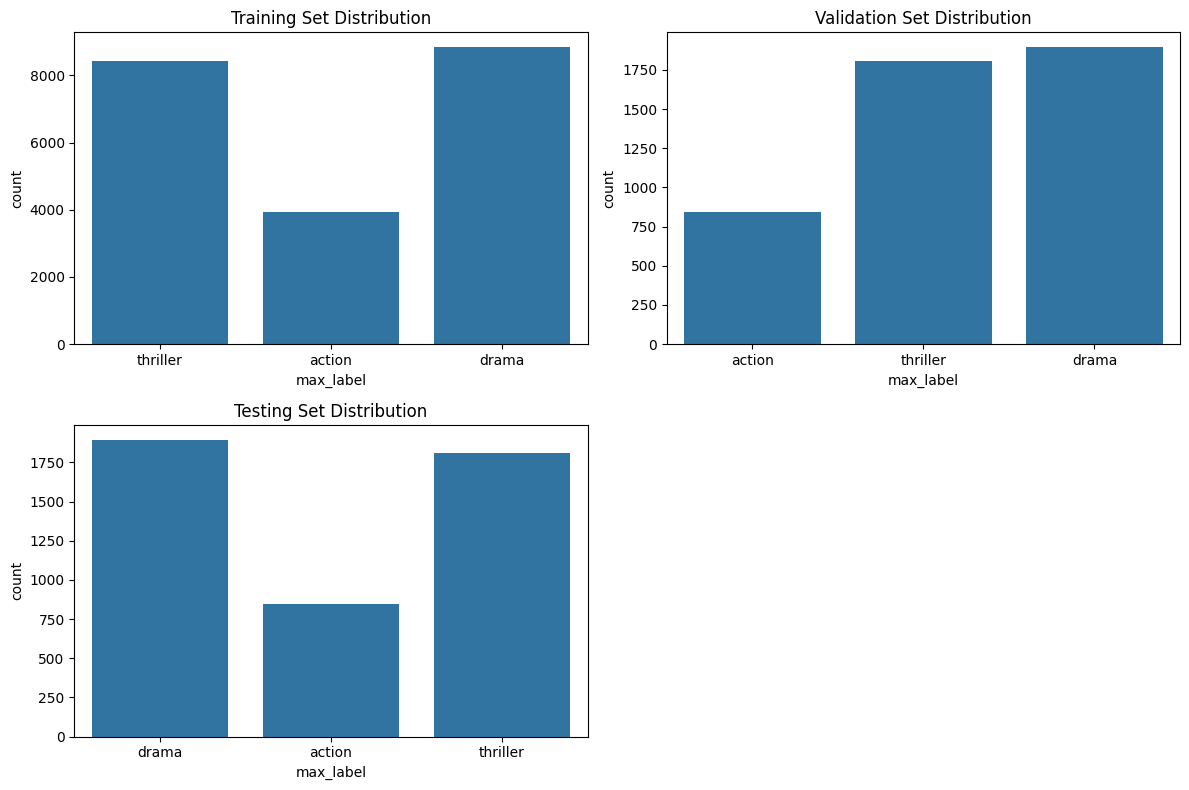

In [6]:
# Plotting the distribution of target labels in each dataset
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
sns.countplot(x='max_label', data=training_set)
plt.title("Training Set Distribution")

plt.subplot(2, 2, 2)
sns.countplot(x='max_label', data=validation_set)
plt.title("Validation Set Distribution")

plt.subplot(2, 2, 3)
sns.countplot(x='max_label', data=test_set)
plt.title("Testing Set Distribution")

plt.tight_layout()
plt.show()

In [7]:
# Check overlap (should be empty)
overlap = set(training_set).intersection(set(test_set.index))
print("Overlap between train and test sets:", overlap)

Overlap between train and test sets: set()


In [8]:
training_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21224 entries, 24155 to 19423
Data columns (total 25 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Episode 1              21224 non-null  object
 1   Time period Episode 1  21224 non-null  object
 2   Genres Episode 1       21224 non-null  object
 3   Episode 2              21224 non-null  object
 4   Time period Episode 2  21224 non-null  object
 5   Genres Episode 2       21224 non-null  object
 6   Episode 3              21224 non-null  object
 7   Time period Episode 3  21224 non-null  object
 8   Genres Episode 3       21224 non-null  object
 9   Episode 4              21224 non-null  object
 10  Time period Episode 4  21224 non-null  object
 11  Genres Episode 4       21224 non-null  object
 12  Episode 5              21224 non-null  object
 13  Time period Episode 5  21224 non-null  object
 14  Genres Episode 5       21224 non-null  object
 15  Episode 6           

# Define the final columns

In [9]:
# Final columns for classification

X_train = training_set.drop(columns=['max_label'])
y_train = training_set['max_label']

X_validation = validation_set.drop(columns=['max_label'])
y_validation = validation_set['max_label']

X_test = test_set.drop(columns=['max_label'])
y_test = test_set['max_label']


# Pipeline

In [10]:
# Imports
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, RobustScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from transformers import GenresTransformer, TimePeriodTransformer

### Preprocessing Pipeline

In [11]:
# Preprocessing pipeline:

genres_columns = [col for col in training_set.columns if col.startswith("Genres")]
episode_columns = [col for col in training_set.columns if col.startswith("Episode")]
time_period_columns = [col for col in training_set.columns if col.startswith("Time period")]

# Get column indices for genres and time periods
genres_indices = [training_set.columns.get_loc(col) for col in genres_columns]
episode_indices = [training_set.columns.get_loc(col) for col in episode_columns]
time_period_indices = [training_set.columns.get_loc(col) for col in time_period_columns]


# First ColumnTransformer for value transformations
value_transformations = ColumnTransformer(
    transformers=[
        ('genre_transformer', GenresTransformer(columns=genres_columns), genres_indices),
        ('time_period_transformer', TimePeriodTransformer(columns=time_period_columns), time_period_indices),
        ('ordinal_encoder', OrdinalEncoder(), episode_indices)
    ],
    remainder='passthrough'
)

# Second ColumnTransformer for scaling and encoding
scaling_encoding = ColumnTransformer(
    transformers=[
        ('robust_scaler', RobustScaler(), time_period_indices)
    ],
    remainder='passthrough'
)

# Combine them into a final pipeline
preprocessing_pipeline = Pipeline([
    ('value_transformations', value_transformations),
    ('scaling_encoding', scaling_encoding)
])


### Full Pipeline

In [12]:

# Define the final pipeline
final_pipeline = Pipeline([
    ('preprocessing', preprocessing_pipeline),  
    ('model', RandomForestClassifier(n_estimators=100, random_state=42))        
])

In [13]:
# Encode the labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_validation_encoded = label_encoder.transform(y_validation)
y_test_encoded = label_encoder.transform(y_test)

In [14]:
final_pipeline.fit(X_train, y_train_encoded)

y_validation_pred = final_pipeline.predict(X_validation)
y_test_pred = final_pipeline.predict(X_test)

### Model Evaluation

In [15]:
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [16]:
# Validation set evaluation
val_accuracy = accuracy_score(y_validation_encoded, y_validation_pred)
print(f"Accuracy on Validation Set: {val_accuracy:.4f}")

# Classification report
print("Classification Report on Validation Set:")
print(classification_report(y_validation_encoded, y_validation_pred))


Accuracy on Validation Set: 0.9866
Classification Report on Validation Set:
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       845
           1       1.00      1.00      1.00      1895
           2       0.99      0.98      0.98      1808

    accuracy                           0.99      4548
   macro avg       0.98      0.98      0.98      4548
weighted avg       0.99      0.99      0.99      4548



In [17]:
# Test set evaluation
test_accuracy = accuracy_score(y_test_encoded, y_test_pred)
print(f"Accuracy on Test Set: {test_accuracy:.4f}")
print("Classification Report on Test Set:")
print(classification_report(y_test_encoded, y_test_pred))

Accuracy on Test Set: 0.9905
Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.97      0.98      0.97       846
           1       1.00      1.00      1.00      1895
           2       0.99      0.99      0.99      1807

    accuracy                           0.99      4548
   macro avg       0.99      0.99      0.99      4548
weighted avg       0.99      0.99      0.99      4548



In [18]:
# Evaluate the model on the training set
y_train_pred = final_pipeline.predict(X_train)
train_accuracy = accuracy_score(y_train_encoded, y_train_pred)
print(f"Accuracy on Training Set: {train_accuracy:.4f}")

# Evaluate the model on the validation set 
val_accuracy = accuracy_score(y_validation_encoded, y_validation_pred)
print(f"Accuracy on Validation Set: {val_accuracy:.4f}")

# Evaluate the model on the test set 
test_accuracy = accuracy_score(y_test_encoded, y_test_pred)
print(f"Accuracy on Test Set: {test_accuracy:.4f}")

# Check for overfitting
print("\nOverfitting Analysis:")
if train_accuracy - val_accuracy > 0.05:
    print("Warning: Possible overfitting detected! Significant accuracy difference between training and validation sets.")
else:
    print("No significant overfitting detected. Model is generalizing well.")


Accuracy on Training Set: 1.0000
Accuracy on Validation Set: 0.9866
Accuracy on Test Set: 0.9905

Overfitting Analysis:
No significant overfitting detected. Model is generalizing well.


# Saving the pipeline

In [178]:
import joblib
joblib.dump(final_pipeline, 'classification_pipeline.pkl')

['classification_pipeline.pkl']

In [179]:
# Save the label encoder
joblib.dump(label_encoder, 'label_encoder.pkl')

['label_encoder.pkl']